## 3. Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


### Existem muitas formas diferentes de se fazer a previsão dos preços dos carros a partir dos dados, poderíamos utilizar muitas abordagens diferentes e por isto o mais indicado seria fazermos previsões usando várias abordagens diferentes que façam sentido neste caso e analisar a performance de cada um dos modelos preditivos gerados, e utilizar todos eles simultâneamente de acordo com o caso onde o modelo ou os modelos específicos se performam melhor.
### Isso seria aconselhável porque a matemática e os modelos buscam generalizações mas a vida real é específica, neste contexto do modelo preditivo podemos ter um determinado tipo de modelo que faz uma previsão com maior acurácia em uma determinada região do Brasil e em outra região ele erra mais, e uma situação similar com outro modelo em outra região, entre outras situações que poderiam acontecer.

### Obviamente neste caso não vai ser possível fazer várias abordagens diferentes e uma análise da performance deles com todo esse nível de profundidade por uma questão de tempo.

### Poderíamos utilizar várias técnicas de feature engineering(utilizar nossas features para gerar outras features e adicionar mais informação relevante para o nosso modelo), poderíamos utilizar várias técnicas de feature importance(avaliar a importância das features para o nosso modelo) e vários modelos de previsão diferentes. Neste caso poderíamos fazer um modelo de regressão e de classificação, no caso de classificação se transformarmos intervalos de preço em variáveis categóricas que indicam um intervalo de preço poderíamos prever a faixa de preço de um carro ao invés de uma previsão pontual que fazemos em regressão e no contexto de negócios o time poderia utilizar aquela faixa de preço em negociações por exemplo.   

### Neste caso vou utilizar a seguinte abordagem:

### Vou tratar o problema como um problema de regressão, e vou dar preferência a modelos que tenha estrutura hierárquica, como por exemplo um modelo que tenha uma estrutura de árvore como o RandomForestRegressor porque temos muitas features categoricas e teoricamente muitas diferenças entre as categorias das features, como por exemplo a feature estado, na prática temos muitas diferenças regionais no Brasil então muitas diferenças entre as categorias dessa feature.

In [4]:
# pra rodar na nuvem google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# bibliotecas usadas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [6]:
# nuvem google colab
# df_train = pd.read_excel("drive/MyDrive/cars_train.xlsx")

In [7]:
# local
df_train = pd.read_excel("cars_train.xlsx")

Vamos observar a distribuição dos preços em geral

Text(0, 0.5, 'Frequência dos preços')

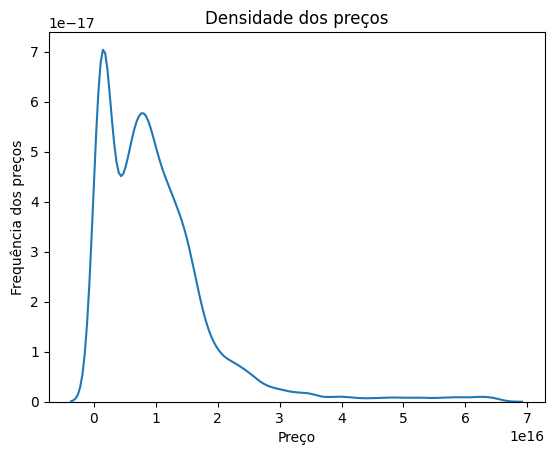

In [8]:
sns.kdeplot(x = df_train['preco'] )
plt.title('Densidade dos preços')
plt.xlabel("Preço")
plt.ylabel("Frequência dos preços")

Podemos observar que o preço tem uma distribuição assimétrica e com dois picos, seria um boa idéia utilizar o logaritmo do preço para suavizar a distribuição.

Text(0, 0.5, 'Frequência dos preços')

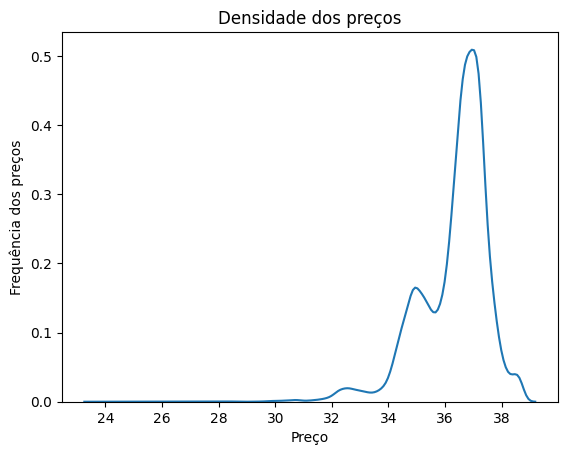

In [9]:
sns.kdeplot(x = np.log(df_train['preco']) )
plt.title('Densidade dos preços')
plt.xlabel("Preço")
plt.ylabel("Frequência dos preços")

In [10]:
df_train['preco'] = np.log(df_train['preco'])

Observamos que a distribuição dos preços é assimétrica, isso é importante de se considerar.

### Feature engineering

Criaremos a variável de categorias para descobrir quais as categorias de carros mais vendidos.

In [11]:
# Create a new variable by combining Feature1 and Feature2
df_train['categoria'] = df_train['marca'].astype(str)+df_train['tipo'].astype(str) +\
df_train['modelo'].astype(str) + df_train['cambio'].astype(str)  + \
df_train['ano_de_fabricacao'].astype(str) + df_train['num_portas'].astype(str) + \
df_train['cor'].astype(str)

In [12]:
df_train.isna().sum()

id                             0
num_fotos                    177
marca                          0
modelo                         0
versao                         0
ano_de_fabricacao              0
ano_modelo                     0
hodometro                      0
cambio                         0
num_portas                     0
tipo                           0
blindado                       0
cor                            0
tipo_vendedor                  0
cidade_vendedor                0
estado_vendedor                0
anunciante                     0
entrega_delivery               0
troca                          0
elegivel_revisao               0
dono_aceita_troca           7662
veiculo_único_dono         19161
revisoes_concessionaria    20412
ipva_pago                   9925
veiculo_licenciado         13678
garantia_de_fábrica        25219
revisoes_dentro_agenda     23674
veiculo_alienado           29584
preco                          0
categoria                      0
dtype: int

### Vamos tratar estes dados faltantes para fazer nosso modelo.

Número de fotos

In [13]:
df_train['num_fotos'].describe()

count    29407.000000
mean        10.323834
std          3.487334
min          8.000000
25%          8.000000
50%          8.000000
75%         14.000000
max         21.000000
Name: num_fotos, dtype: float64

Existem várias técnicas pra tratar dados númericos faltantes, neste caso como o desvio-padrão que corresponde a std = 3 na tabela é pequeno, e a distância interquartil também não é grande( 14-8 = 6 ) vamos substituir os dados faltantes pela média mesmo para não adicionar muita variação aos dados, e no num_fotos também não temos muitos dados faltantes além de ser uma variável discreta, então isso já vai ser o suficiente.

In [14]:
df_train['num_fotos'] = df_train['num_fotos'].fillna(3.487334)

In [15]:
df_train['num_fotos'].describe()

count    29584.000000
mean        10.282932
std          3.516633
min          3.487334
25%          8.000000
50%          8.000000
75%         14.000000
max         21.000000
Name: num_fotos, dtype: float64

Como esperado adicionar a média no lugar dos dados faltantes não afetou muito a distribição dos dados.

As features: dono_aceita_troca, veiculo_único_dono, revisões_concessionarias, ipva_pago, veiculo_licenciado, veiculo_alienado, garantia_de_fábrica e revisoes_dentro_agenda são dicotômicas e suas únicas respostas tem conotação positiva então vamos fazer a suposição de que os dados faltantes estão indicando o negativo para o que a feature indica.

In [16]:
df_train['dono_aceita_troca'].value_counts()

dono_aceita_troca
Aceita troca    21922
Name: count, dtype: int64

In [17]:
df_train['veiculo_único_dono'].value_counts()

veiculo_único_dono
Único dono    10423
Name: count, dtype: int64

In [18]:
df_train['revisoes_concessionaria'].value_counts()

revisoes_concessionaria
Todas as revisões feitas pela concessionária    9172
Name: count, dtype: int64

In [19]:
df_train['ipva_pago'].value_counts()

ipva_pago
IPVA pago    19659
Name: count, dtype: int64

In [20]:
df_train['veiculo_licenciado'].value_counts()

veiculo_licenciado
Licenciado    15906
Name: count, dtype: int64

In [21]:
df_train['veiculo_alienado'].value_counts()

Series([], Name: count, dtype: int64)

In [22]:
df_train['garantia_de_fábrica'].value_counts()

garantia_de_fábrica
Garantia de fábrica    4365
Name: count, dtype: int64

In [23]:
df_train['revisoes_dentro_agenda'].value_counts()

revisoes_dentro_agenda
Todas as revisões feitas pela agenda do carro    5910
Name: count, dtype: int64

Por conta disso seria legal transformar essas variáveis dicotomicas em zero no caso onde falta a feature e igual a 1 no caso que houve a resposta positiva, e também transformar as outras variáveis categóricas em números que indicam as categorias para ajustarmos os modelos sem problemas.

In [24]:
df_train['modelo'] = df_train['modelo'].astype(str)
df_train['ano_de_fabricacao'] = df_train['ano_de_fabricacao'].astype(str)
df_train['ano_modelo'] = df_train['ano_modelo'].astype(str)


In [25]:
# preencher os espaços vazios
# e depois transformar em variável numérica

colunas = list(df_train.columns)
colunas.remove('id')
colunas.remove('num_fotos')
colunas.remove('hodometro')
colunas.remove('num_portas')
colunas.remove('preco')

encoder = LabelEncoder()
for coluna in colunas :
    df_train[coluna] = df_train[coluna].fillna('negativo')
    df_train[coluna] = encoder.fit_transform(df_train[coluna])

Dessa forma conseguimos fazer a transformação desejada.

In [26]:
df_train.head()

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,...,dono_aceita_troca,veiculo_único_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fábrica,revisoes_dentro_agenda,veiculo_alienado,preco,categoria
0,300716223898539419613863097469899222392,8.0,27,257,424,29,10,67772.0,4,4,...,1,0,0,0,0,1,1,0,36.550108,4324
1,279639842134129588306469566150288644214,8.0,18,133,876,29,10,62979.0,2,4,...,0,0,1,0,1,1,1,0,36.642488,2908
2,56414460810621048900295678236538171981,16.0,19,378,1402,30,12,44070.0,2,4,...,0,0,1,1,1,1,1,0,30.421111,3055
3,56862509826849933428086372390159405545,14.0,38,63,1087,25,8,85357.0,2,4,...,0,0,1,0,0,1,1,0,37.053900,5627
4,338980975753200343894519909855598027197,8.0,33,259,1076,25,8,71491.0,2,4,...,1,0,0,1,1,0,0,0,34.345431,4910


### Vamos testar algumas abordagens diferentes

Vamos testar uma predição com e sem feature importance, vamos utilizar o método Select K-best com a função score mutual_info_regression, o método ordena as features apartir da sua importância para explicar a variável alvo que é calculada usando uma função que atribui um score para a feature e então selecionamos as K features mais importantes para explicar a variável alvo.

Criando os vetores X = features e y = target.

In [27]:
X = df_train.drop(columns=['id','preco'])
y = df_train['preco']
y = y.astype('float64')

In [28]:
# usando feature selection
feat_imp = SelectKBest(score_func=mutual_info_regression, k='all')
feat_imp.fit(X, y)
X_train_fi = feat_imp.transform(X)

In [29]:
X.shape

(29584, 28)

In [30]:
X_train_fi.shape

(29584, 28)

Podemos obervar que o método de seleção de features nos retornou o data set com todas as colunas, então podemos descartar a hipótese de que algumas features sejam menos importantes para explicar a variável alvo, então vamos prosseguir com todas as features.

# Previsão

## Vamos testar três modelos:
## - Random Forest Regression
## - Decision tree Regression
## - K Neighbors regression (um modelo inspirado nos k-vizinhos mais próximos mas adaptado para regressão)
## - Modelos ensemble para regressão, são conjuntos de modelos onde utilizamos a previsão de todos os modelos para fazer a previsão.

### Para avaliar a capacidade de generalização dos modelos vamos utilizar a técnica de validação cruzada houldout e cross validation, onde vamos dividir os dados entre dados de treino e dados de teste em uma certa proporção, o recomendado é ter mais dados de treino do que de teste, no caso vamos ter 40% de dados de teste e 60% de dados de treino, e vamos repetir este processo algumas vezes para não correr o risco de selecionar aleatoriamente uma amostra dos dados que não seja representativa para treinar o nosso modelo, no nosso caso vamos repetir este processo 3 vezes pois o custo computacional dos nossos modelos está um pouco grande e está demorando um pouco para rodar, mas poderíamos fazer mais.

### Métricas para avaliar o modelo de regressão:

### Como estamos lidando com um modelo de regressão que faz a previsão de uma quantidade numérica é muito difícil prever corretamente a quantidade numérica sem nenhum tipo de erro, então temos que escolher o modelo de regressão que comete menos erros na previsão.

### Denominamos essa diferença entre o valor que o modelo prevê e o valor verdadeiro de resíduo, e temos várias técnicas métricas para avaliar os resíduos do modelos que vamos utilizar, elas são:

# Vamos utilizar as seguintes métricas:

## Root Mean Squared Error (RMSE) em português Raiz do Erro Quadrático Médio(REQM)

### $MSE= \sqrt{\frac{1}{N}\sum_{i=1}^{N}(\hat y_i - y_i)^2 } $

 - N é o número total de observações
 - $\hat y_i$ é o i-ésimo valor predito.
 - $ y_i $ é o i-ésimo valor verdadeiro na nossa variável alvo.

## Retiramos a raiz das diferenças ao quadrado pois se não elevarmos as diferenças ao quadrado teoricamente a soma tenderia a zero, porque teoricamente se o modelo esta bem ajustado ele retorna erros aleatórios pois ele captou os padrões existentes nos dados. E após retirar a média das diferenças ao quadrado retiramos a raiz para podermos interpretar a medida com maior facilidade.

## Mean Absolute Error (MAE) em português Erro absoluto médio(EAM)

### $MSE= \frac{1}{N}\sum_{i=1}^{N}|\hat y_i - y_i| $

 - N é o número total de observações
 - $\hat y_i$ é o i-ésimo valor predito.
 - $ y_i $ é o i-ésimo valor verdadeiro na nossa variável alvo.

## Nesta métrica retiramos a média do módulo das diferenças entre os valores preditos e os valores reais.

## Mean Percentage Error(MPE) ou Erro Percentual Absoluto Médio

### $MPE= \frac{1}{N}\sum_{i=1}^{N}\frac{|\hat y_i - y_i|}{y_i} $

## O Erro percentual absoluto médio retorna o erro percentual médio cometido pelo modelo ao fazer um previsão.

## É importante lembrar que como estamos lidando com uma regressão não-linear pois os nossos preços não tem comportamento linear, não podemos utilizar a métrica R-quadrado(R2) comumente usada para validar modelos de regressão lineares, pois esta métrica é invalida em modelos de regressão onde a variável dependente tem comportamento não linear.

## Também vamos fazer plots dos resíduos

In [31]:
# Modelos juntos com alguns hiperparâmetros para melhorar a performance.
# Random Forest Regressor
rfr_m = RandomForestRegressor(n_estimators=300)

# K Neighbors regressor
kr_m = KNeighborsRegressor(n_neighbors=25 , weights='distance')

# decision tree regressor
dtr_m = DecisionTreeRegressor(criterion='absolute_error')

# Voting regressor
vot = VotingRegressor([('rfr', rfr_m), ('kr', kr_m),('dct', dtr_m)])

# ATENÇÃO!! Esse PRÓXIMO BLOCO DE CÓDIGO DEMORA bastante tempo para EXECUTAR, cerca de 5 MINUTOS.

In [32]:
# cross validation, feita manualmente para fazermos os reajustes no mesmo modelo
# para utilizarmos para previsão depois.

rmse_rfr = []
rmse_kr = []
rmse_dtr = []
rmse_vot = []

mae_rfr = []
mae_kr = []
mae_dtr = []
mae_vot = []

mpe_rfr = []
mpe_kr = []
mpe_dtr = []
mpe_vot = []

for i in range(0,3):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
  vot.fit(X_train, y_train)
  preds = pd.DataFrame(vot.transform(X_test)) # predição dos modelos individualmente
  vot_pred = vot.predict(X_test) # predição do voting regressor que tira uma média das regressões

  rmse_rfr.append(mean_squared_error(y_test, preds.iloc[:,0])) # rmse dos modelos individualmente
  rmse_dtr.append(mean_squared_error(y_test, preds.iloc[:,1]))
  rmse_kr.append(mean_squared_error(y_test, preds.iloc[:,2]))
  rmse_vot.append(mean_squared_error(y_test, vot_pred)) # e rmse voting

  mae_rfr.append(mean_absolute_error(y_test, preds.iloc[:,0])) # mean absolute error individuais
  mae_dtr.append(mean_absolute_error(y_test, preds.iloc[:,1]))
  mae_kr.append(mean_absolute_error(y_test, preds.iloc[:,2]))
  mae_vot.append(mean_absolute_error(y_test, vot_pred)) # mean absolute error voting regressor

  per_rfr = np.abs((y_test - preds.iloc[:,0]) / preds.iloc[:,0]) * 100
  mpe_rfr.append(np.mean(per_rfr))
  per_kr = np.abs((y_test - preds.iloc[:,1]) / preds.iloc[:,1]) * 100
  mpe_kr.append(np.mean(per_kr))
  per_dtr = np.abs((y_test - preds.iloc[:,2]) / preds.iloc[:,2]) * 100
  mpe_dtr.append(np.mean(per_dtr))
  per_vot = np.abs((y_test - vot_pred) / vot_pred) * 100
  mpe_vot.append(np.mean(per_vot))


In [33]:
print(' RMSE médio da cross validation do Random Forest Regressor:', np.mean(rmse_rfr), '\n',
'RMSE médio da cross validation do Decision Tree Regressor:', np.mean(rmse_dtr), '\n',
'RMSE médio da cross validation do K-Neighbors regression:', np.mean(rmse_kr), '\n',
'RMSE médio da cross validation do Voting regression:', np.mean(rmse_vot) )


 RMSE médio da cross validation do Random Forest Regressor: 1.60199034841822 
 RMSE médio da cross validation do Decision Tree Regressor: 1.583008572282151 
 RMSE médio da cross validation do K-Neighbors regression: 3.2544626524286624 
 RMSE médio da cross validation do Voting regression: 1.7486428182996703


In [34]:
print(' MAE médio da cross validation do Random Forest Regressor:', np.mean(mae_rfr), '\n',
'MAE médio da cross validation do Decision Tree Regressor:', np.mean(mae_dtr), '\n',
'MAE médio da cross validation do K-Neighbors regression:', np.mean(mae_kr), '\n',
'MAE médio da cross validation do Voting regression:', np.mean(mae_vot) )

 MAE médio da cross validation do Random Forest Regressor: 0.9601249638112824 
 MAE médio da cross validation do Decision Tree Regressor: 0.9490459470417213 
 MAE médio da cross validation do K-Neighbors regression: 1.2505617659012163 
 MAE médio da cross validation do Voting regression: 0.9874541266871649


In [35]:
print(' MPE médio da cross validation do Random Forest Regressor:', np.mean(mpe_rfr), '\n',
'MPE médio da cross validation do Decision Tree Regressor:', np.mean(mpe_dtr), '\n',
'MPE médio da cross validation do K-Neighbors regression:', np.mean(mpe_kr), '\n',
'MPE médio da cross validation do Voting regression:', np.mean(mpe_vot) )

 MPE médio da cross validation do Random Forest Regressor: 2.6732843310542935 
 MPE médio da cross validation do Decision Tree Regressor: 3.7547038470107683 
 MPE médio da cross validation do K-Neighbors regression: 2.608292699577627 
 MPE médio da cross validation do Voting regression: 2.728398428410339


## Observando as métricas podemos observar que os modelos tiveram poucas diferenças em suas métricas e de acordo com nossas métricas o nosso modelo está fazendo previsões de maneira aceitável com o voting regression cometendo aproximadamente 2.733% de erro percentual em suas previsões.

In [36]:
pred_dataset = pd.DataFrame(vot.transform(X))
vot_dataset = vot.predict(X)

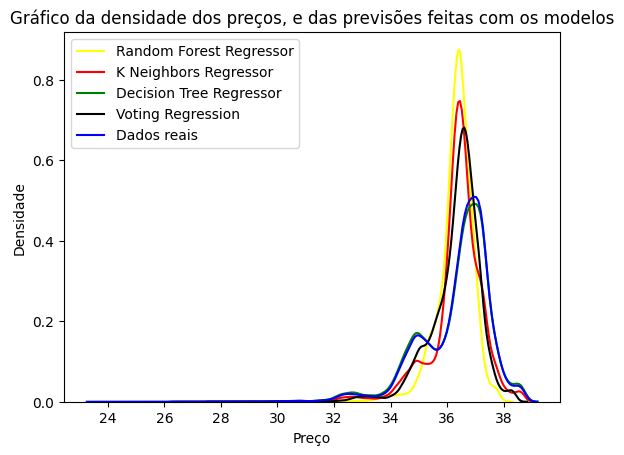

In [37]:
fig, ax = plt.subplots()

sns.kdeplot(x = pred_dataset.iloc[:,0], color='yellow', label='Random Forest Regressor',ax=ax)
sns.kdeplot(x = pred_dataset.iloc[:,1], color='red', label='K Neighbors Regressor',ax=ax)
sns.kdeplot(x = pred_dataset.iloc[:,2], color='green', label='Decision Tree Regressor',ax=ax)
sns.kdeplot(x = vot_dataset, color='black', label='Voting Regression',ax=ax)
sns.kdeplot(x = y, color='blue', label='Dados reais',ax=ax)

ax.set_title('Gráfico da densidade dos preços, e das previsões feitas com os modelos')
ax.set_xlabel('Preço')
ax.set_ylabel('Densidade')

# Add a legend using Matplotlib
ax.legend()

# Apply Seaborn style to the plot
sns.set()

# Display the plot
plt.show()


# Análise dos resíduos

## Resíduos normalizados - Nesta métrica calculamos os resíduos e dividimos eles pelo seu desvio-padrão para normalizar os resíduos, isto é útil para termos uma noção da distribuiçãio dos resíduos além de identificar se tem muitos resíduos grandes e também podemos ter uma noção aproximada de quantos desvio-padrões a nossa previsão esta errando observando o gráfico.

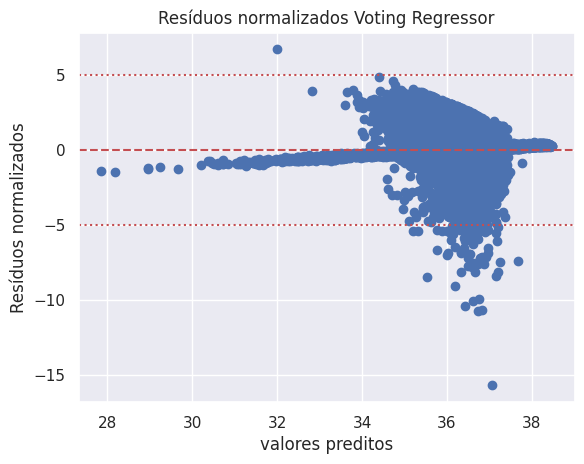

In [38]:
residuals = y - vot_dataset

# Calculate normalized residuals
std_dev = np.std(residuals)
normalized_residuals = residuals / std_dev

# Plot normalized residuals
plt.scatter(vot_dataset, normalized_residuals)
plt.xlabel("valores preditos")
plt.ylabel("Resíduos normalizados")
plt.title("Resíduos normalizados Voting Regressor")
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=5, color='r', linestyle=':')
plt.axhline(y=-5, color='r', linestyle=':')
plt.show()

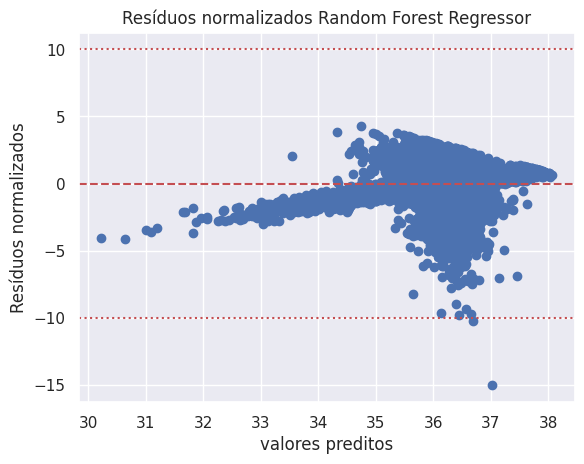

In [39]:
residuals = y - pred_dataset.iloc[:,0]

# Calculate normalized residuals
std_dev = np.std(residuals)
normalized_residuals = residuals / std_dev

# Plot normalized residuals
plt.scatter(pred_dataset.iloc[:,0], normalized_residuals)
plt.xlabel("valores preditos")
plt.ylabel("Resíduos normalizados")
plt.title("Resíduos normalizados Random Forest Regressor")
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=10, color='r', linestyle=':')
plt.axhline(y=-10, color='r', linestyle=':')
plt.show()

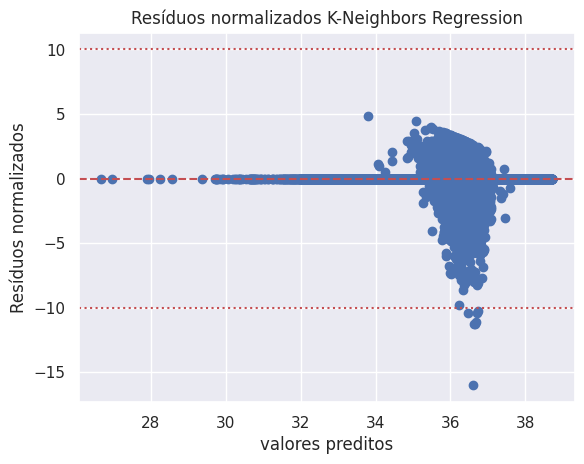

In [40]:
residuals = y - pred_dataset.iloc[:,1]

# Calculate normalized residuals
std_dev = np.std(residuals)
normalized_residuals = residuals / std_dev

# Plot normalized residuals
plt.scatter(pred_dataset.iloc[:,1], normalized_residuals)
plt.xlabel("valores preditos")
plt.ylabel("Resíduos normalizados")
plt.title("Resíduos normalizados K-Neighbors Regression")
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=10, color='r', linestyle=':')
plt.axhline(y=-10, color='r', linestyle=':')
plt.show()

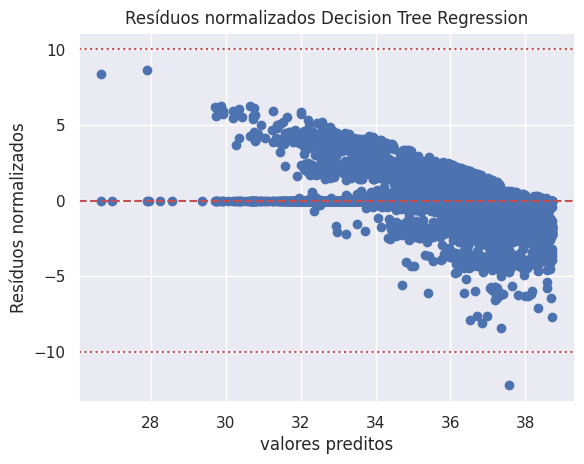

In [41]:
residuals = y - pred_dataset.iloc[:,2]

# Calculate normalized residuals
std_dev = np.std(residuals)
normalized_residuals = residuals / std_dev

# Plot normalized residuals
plt.scatter(pred_dataset.iloc[:,2], normalized_residuals)
plt.xlabel("valores preditos")
plt.ylabel("Resíduos normalizados")
plt.title("Resíduos normalizados Decision Tree Regression")
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=10, color='r', linestyle=':')
plt.axhline(y=-10, color='r', linestyle=':')
plt.show()

Teoricamente ao normalizarmos os resíduos eles ficam na distribuição normal padrão com média zero e desvio padrão igual a 1, podemos observar que temos alguns resíduos com bastante desvios e outras com desvios menores e que mesmo os maiores desvios estão entre 10 desvios-padrão de distância da origem.

Por mais que o modelo apresentasse erro percentual médio entre 2-3% ele erra bastante em algumas previsões, e de fato em algumas previsões podemos ver que o erro não é tão grande assim. E por mais que o decision tree tenha uma densidade de preços praticamente idêntica aos dados reais ele apresenta resíduos mais dispersos do que os outros modelos porque na hora de fazer as previsões pontuais ele erra mais como podemos observar no seu erro percentual médio que é o maior entre os modelos e no gráfico de resíduos normalizados.

Para fazer a previsão nos dados de teste vou utilizar o Voting Regression pois ele retira uma média dos modelos e como não queremos ter um modelo que é sobreajustado aos dados ou sub-ajustado não seria uma má idéia utilizar a média deles.

Dados de teste

In [43]:
# abrir no drive
# df_test = pd.read_excel("drive/MyDrive/cars_test.xlsx")

In [44]:
# local
df_test = pd.read_excel("cars_test.xlsx")

In [45]:
#tratamento nos dados teste
df_test.isna().sum()

id                            0
num_fotos                    60
marca                         0
modelo                        0
versao                        0
ano_de_fabricacao             0
ano_modelo                    0
hodometro                     0
cambio                        0
num_portas                    0
tipo                          0
blindado                      0
cor                           0
tipo_vendedor                 0
cidade_vendedor               0
estado_vendedor               0
anunciante                    0
entrega_delivery              0
troca                         0
elegivel_revisao              0
dono_aceita_troca          2554
veiculo_único_dono         6387
revisoes_concessionaria    6795
ipva_pago                  3298
veiculo_licenciado         4518
garantia_de_fábrica        8439
revisoes_dentro_agenda     7869
veiculo_alienado           9862
dtype: int64

In [46]:
# Create a new variable by combining Feature1 and Feature2
df_test['categoria'] = df_test['marca'].astype(str)+df_test['tipo'].astype(str) +\
df_test['modelo'].astype(str) + df_test['cambio'].astype(str)  + \
df_test['ano_de_fabricacao'].astype(str) + df_test['num_portas'].astype(str) + \
df_test['cor'].astype(str)

In [47]:
df_test['num_fotos'].describe()

count    9802.000000
mean       10.323811
std         3.462367
min         8.000000
25%         8.000000
50%         8.000000
75%        14.000000
max        21.000000
Name: num_fotos, dtype: float64

In [48]:
df_test['num_fotos'] = df_test['num_fotos'].fillna(3.462367)

In [49]:
df_test['modelo'] = df_test['modelo'].astype(str)
df_test['ano_de_fabricacao'] = df_test['ano_de_fabricacao'].astype(str)
df_test['ano_modelo'] = df_test['ano_modelo'].astype(str)

In [50]:
# preencher os espaços vazios
# e depois transformar em variável numérica

colunas = list(df_test.columns)
colunas.remove('id')
colunas.remove('num_fotos')
colunas.remove('hodometro')
colunas.remove('num_portas')

encoder = LabelEncoder()
for coluna in colunas :
    df_test[coluna] = df_test[coluna].fillna('negativo')
    df_test[coluna] = encoder.fit_transform(df_test[coluna])

In [51]:
ids = df_test['id']

In [52]:
pred_test = vot.predict(df_test.drop(columns='id' ) )

Como o nosso modelo prevê o logaritmo do preço temos que fazer E^(número predito) para termos a previsão na unidade do problema

In [53]:
pred_test

array([35.39899897, 36.29300248, 36.44959665, ..., 35.73283578,
       36.98014771, 36.63675707])

In [54]:
pred_test = np.exp(pred_test)

In [55]:
predicao_teste_final = pd.DataFrame(
    {'id': ids,
    'preco': pred_test}
)

In [56]:
predicao_teste_final.shape

(9862, 2)

In [57]:
predicao_teste_final.to_csv('predicted.csv', index = False)
predicao_teste_final.to_excel('predicted.xlsx', index = False)

In [59]:
predicao_teste_final.head()

,id,preco
0,13518783164498355150900635905895481162,2.363687e+15
1,299896161723793383246777788797566040330,5.778974e+15
2,316180649972302128246133616457018378621,6.758630e+15
3,222527157104148385909188217274642813298,7.987749e+15
4,160460343059850745858546502614838368036,4.762497e+15
